# Dengue Exploratory Spatial Analysis for Brazilian Legal Amazon municipalities

## 0. Imports

### 0.1. Libraries

In [1]:
# Data manipulation libraries
import pandas                as pd
import numpy                 as np
import geopandas             as gpd

# Visualization libraries
import seaborn               as sns
import matplotlib            as mpl
import matplotlib.pyplot     as plt

from matplotlib              import cm
from matplotlib.colors       import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable

# ESDA libraries
from esda.moran             import Moran, Moran_Local
from splot.esda             import moran_scatterplot, lisa_cluster
from splot.esda             import plot_moran, plot_local_autocorrelation

from libpysal.weights.contiguity import Queen
from splot.libpysal              import plot_spatial_weights

# Other
import warnings
import sys
import os

### 0.2. Settings

In [2]:
# Ignoring warnings
warnings.filterwarnings('ignore')

# Pandas Settings
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None)

# Visualization Settings
%matplotlib inline

# Set a style
mpl.style.use('ggplot')  

# Customize rcParams
mpl.rcParams.update({
    'axes.titlesize': 24,
    'axes.labelsize': 16,
    'axes.facecolor': 'white',
    'axes.linewidth': 1,
    'axes.grid': True,
    'xtick.labelsize': 16,
    'xtick.bottom': False,
    'ytick.labelsize': 16,
    'ytick.left': False,
    'legend.fontsize': 16,
    'lines.linewidth': 2,
    'lines.markersize': 6,
    'grid.color': 'lightgray',
    'grid.linestyle': '-',
    'grid.linewidth': 0.5,
    'font.size': 16,
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
    'figure.titlesize': 24,
    'figure.figsize': (16,8),
    'figure.dpi': 150
})

### 0.3. Functions

In [3]:
def set_plot(fig, title, xlabel, ylabel):
    """
    Summary: This function sets the plot configuration for the initial plots. 
    Args:
        fig: the figure object.
        title: the title of the plot.
        xlabel: the label for the x axis.
        ylabel: the label for the y axis.
    Returns: figure with the image configuration.
    """
    # Customizing
    fig.set_title(title)
    fig.set_xlabel(xlabel, color='black')
    fig.set_ylabel(ylabel, color='black')

    return fig

### 0.4. Classes

### 0.5. Datasets

In [4]:
# Casos
df_casos = pd.read_csv('../data/interim/mun_dengue_casos_amazonia_legal.csv')

# Óbitos
df_obitos = pd.read_csv('../data/interim/mun_dengue_obitos_amazonia_legal.csv')

In [5]:
# População
df_pop = pd.read_csv('../data/interim/mun_populacao.csv')

In [6]:
# GeoDataFrame MU Brasil
gdf = gpd.read_file('../data/interim/amazonia_legal.geojson')

In [7]:
# Amazônia Legal Brasileira
alb = pd.read_csv('../data/interim/mun_amazonia_legal.csv')

## 1. Data Preparation

### Listas Auxiliares

In [8]:
# Lista de municípios da ALB
lista_mun_alb = alb.cod_ibge.to_list()

### Ajustando População

In [9]:
# Filtrando os dados
df_pop = df_pop[df_pop['cod_ibge'].isin(lista_mun_alb)]

# Ajustando os anos
df_pop['2023'] = df_pop['2022']

# Dropping 
df_pop.drop(columns=['nome_municipio', 'sigla_UF'], inplace=True)

# Melt
df_pop = pd.melt(df_pop, id_vars=['cod_ibge', 'id_mun'], var_name='ano', value_name='pop')

# Changing types
df_pop = df_pop.astype('int64')

### Taxa de Incidência

In [10]:
# Calculando taxa de incidência
df_txinc = pd.merge(df_pop, df_casos, on=['cod_ibge', 'id_mun', 'ano'], how='left')

# Corrigindo para municípios com anos faltantes que agora têm valor NaN
df_txinc = df_txinc.fillna(0)
df_txinc['casos'] = df_txinc['casos'].astype('int64')

# Casos / População * 100,000 habitantes
df_txinc['txinc'] = df_txinc['casos'] / df_txinc['pop'] * 100000

# Filtrando
df_txinc = df_txinc[['cod_ibge', 'id_mun', 'ano', 'txinc']]

# Corrigindo para municípios que não existiam 
df_txinc = df_txinc.fillna(0)

In [11]:
# Filtrando Taxa de Incidência de acordo com anos 
aux = df_txinc[df_txinc['ano'].isin([2019, 2020, 2021, 2022, 2023])]\
      .groupby('id_mun')['txinc'].mean().reset_index() # Média

# Display
aux

,id_mun,txinc
0,110001,974.03
1,110002,351.40
2,110003,740.39
3,110004,641.44
4,110005,437.39
...,...,...
767,510860,210.51
768,510880,1106.18
769,510885,809.69
770,510890,1116.83


In [12]:
aux['txinc'].describe()

count    772.00
mean     386.76
std      573.44
min        0.00
25%       23.65
50%      141.16
75%      511.36
max     4146.95
Name: txinc, dtype: float64

In [13]:
# Taxa de Incidência Média entre os anos de 2019 e 2023
y = aux['txinc'].values

## 2. ESDA - Exploratory Spatial Data Analysis

In [14]:
# Creating a spatial weights matrix using the Queen contiguity criterion
w = Queen.from_dataframe(gdf, use_index=False)

# Row-standardization
w.transform = 'r'

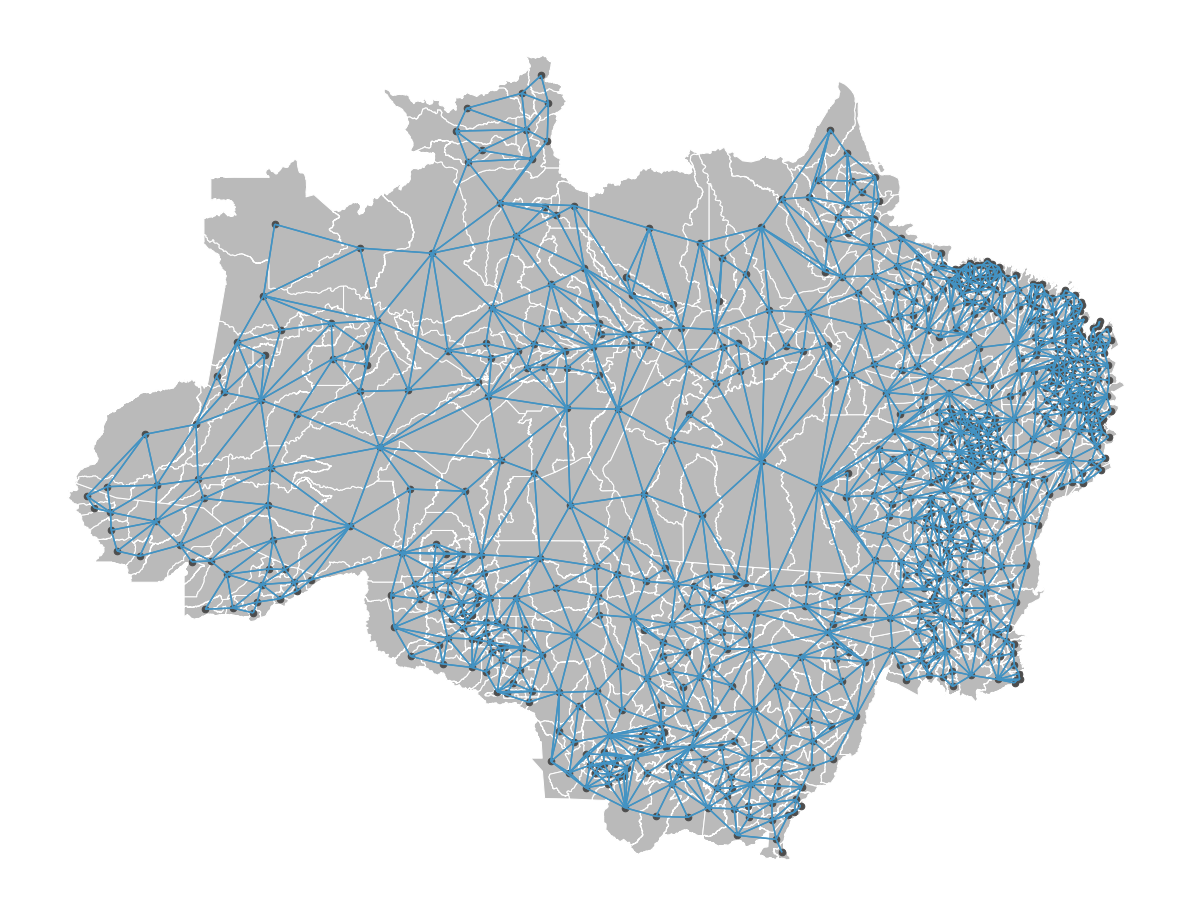

In [15]:
plot_spatial_weights(w, gdf)
plt.show()

In [16]:
# Calculating the Moran's I statistic
moran = Moran(y, w)

# Printing the I statistic
moran.I

np.float64(0.5381375192595638)

In [17]:
moran.p_sim

np.float64(0.001)

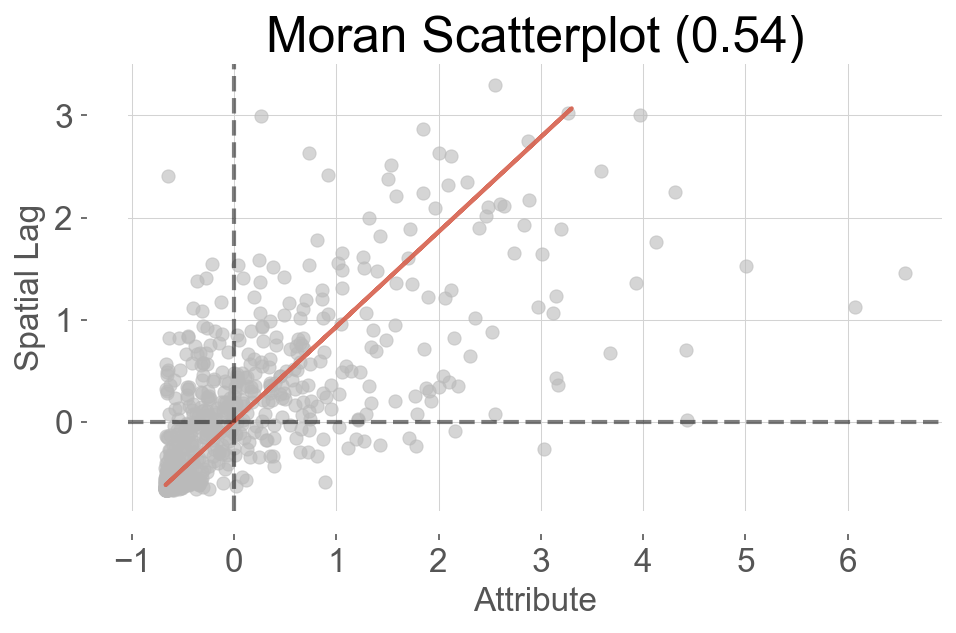

In [18]:
# Moran scatterplot
fig, ax = moran_scatterplot(moran, aspect_equal=True)
plt.show()

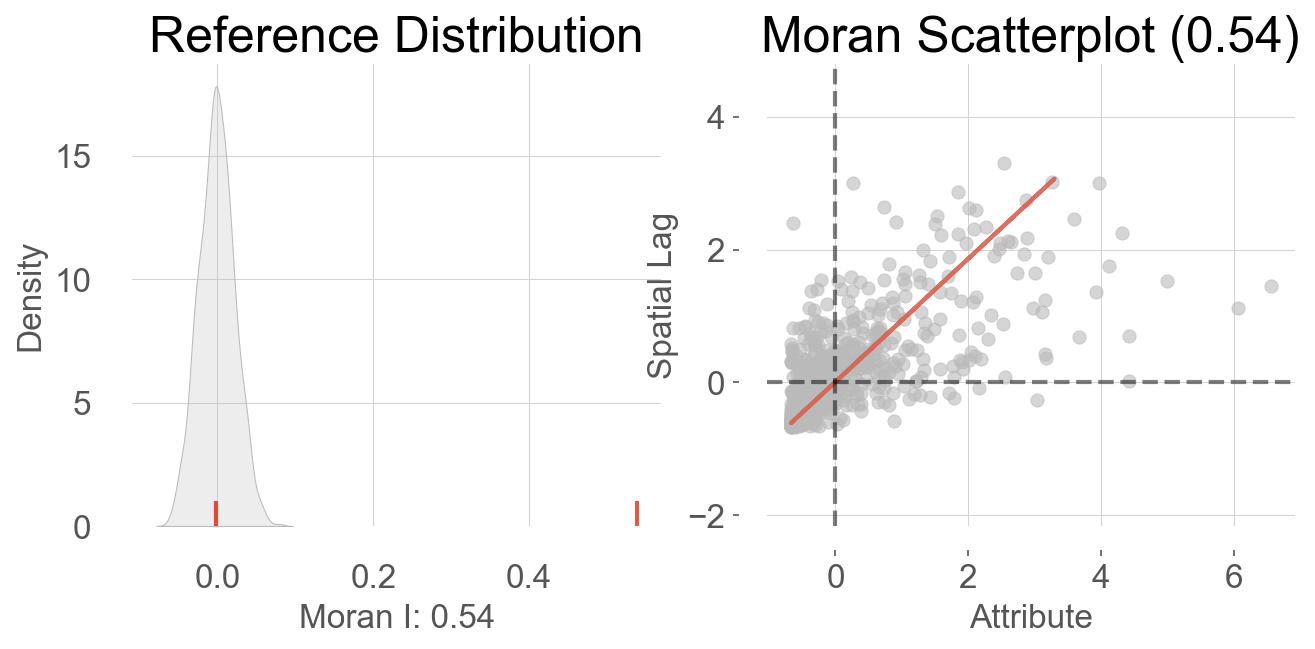

In [19]:
# Global Moran's I Distribution and Scatterplot
# zstandard=True to standardize the values to mean 0 and variance 1
plot_moran(moran, zstandard=True, figsize=(10,4)) 
plt.show()

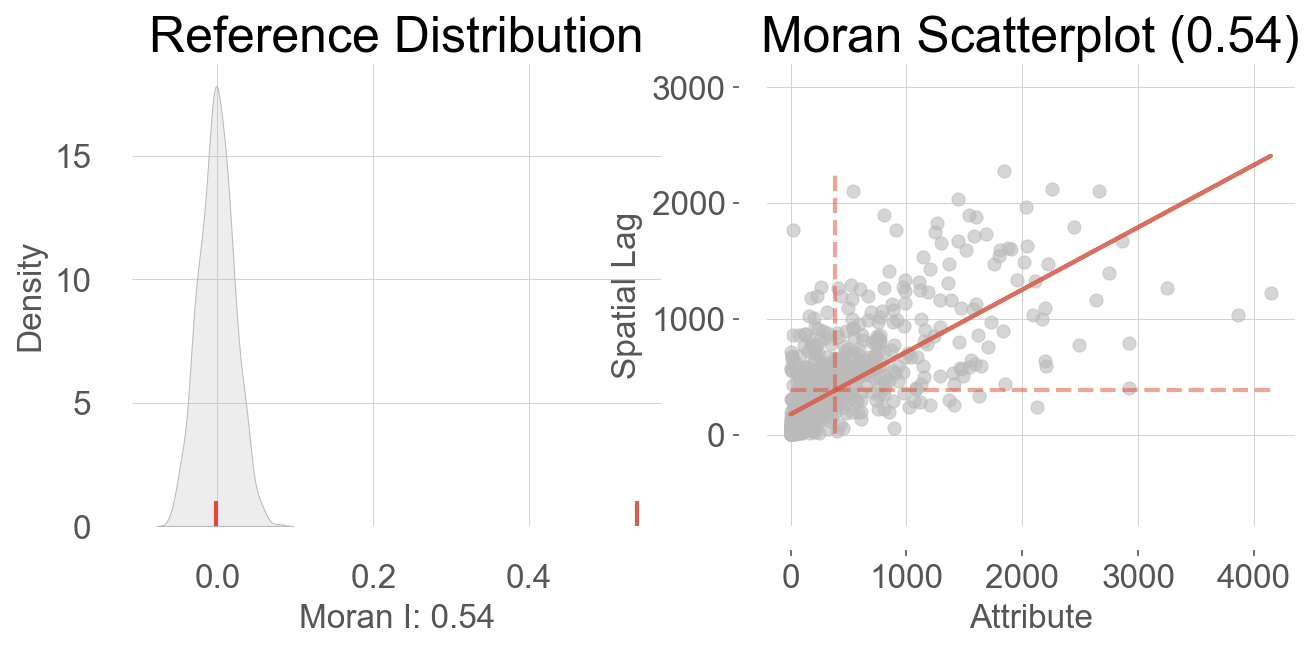

In [20]:
# Global Moran's I Distribution and Scatterplot
plot_moran(moran, zstandard=False, figsize=(10,4))
plt.show()

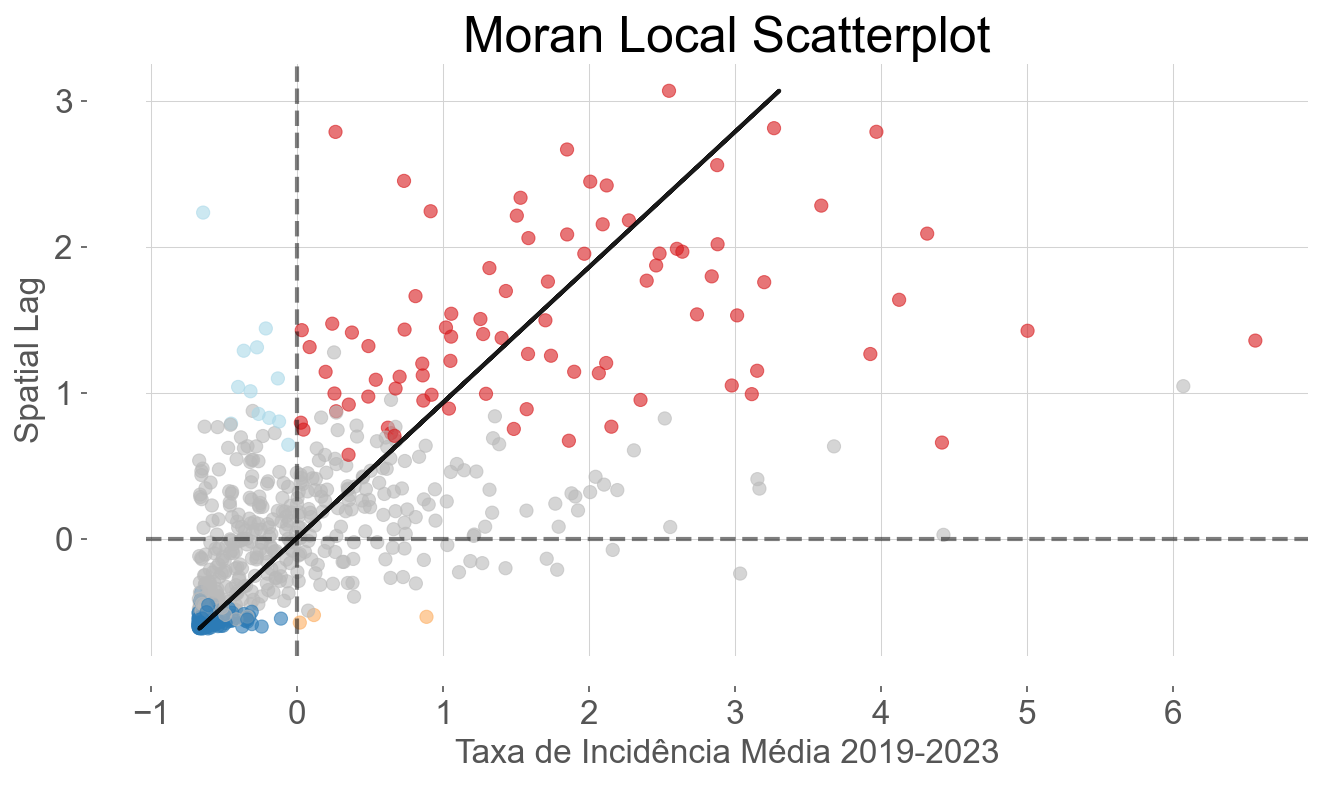

In [21]:
# Moran Local I Scatterplot
moran_loc = Moran_Local(y, w)
fig, ax = moran_scatterplot(moran_loc, p=0.05, zstandard=True)
fig.set_size_inches(10,50)

ax.set_xlabel('Taxa de Incidência Média 2019-2023')
ax.set_ylabel('Spatial Lag')
plt.show()

(<Figure size 2400x1200 with 1 Axes>, <Axes: >)

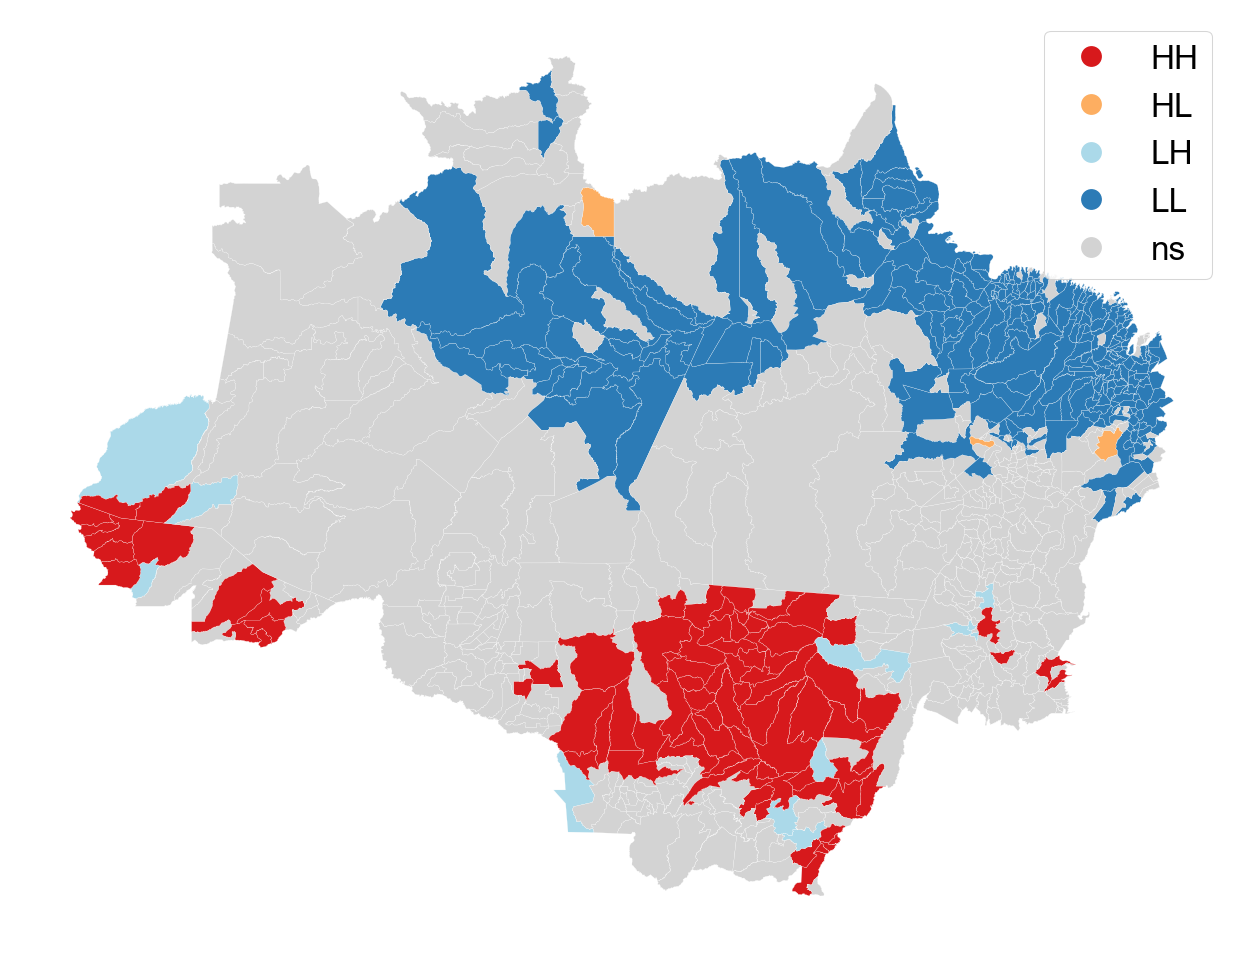

In [22]:
# LISA Cluster map
lisa_cluster(moran_loc, gdf, p=0.05)

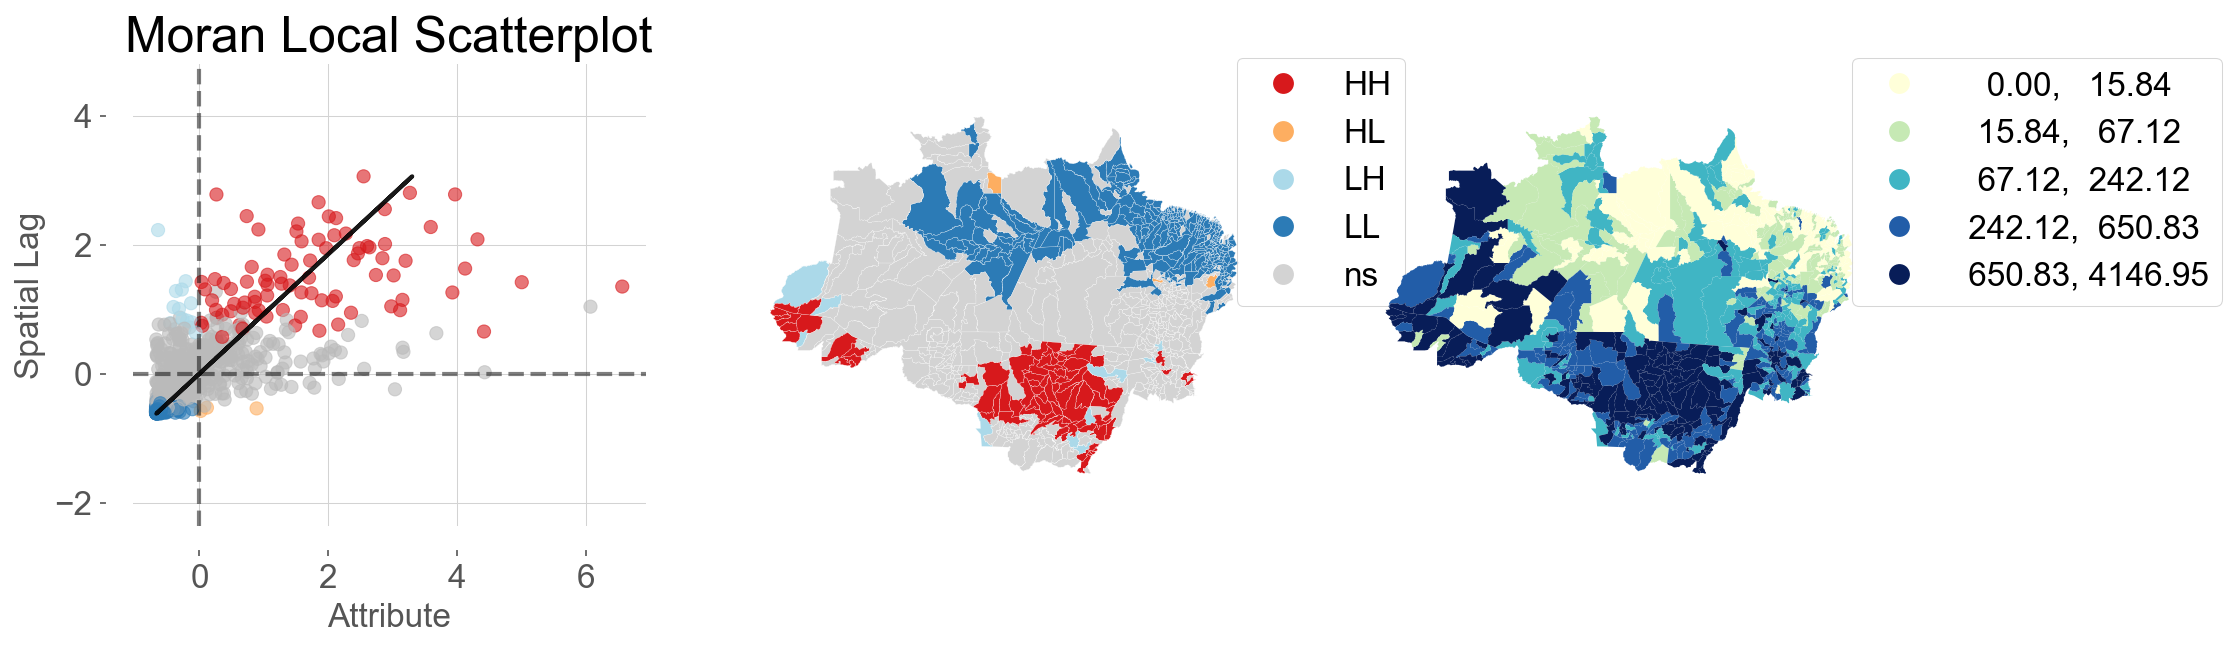

In [23]:
plot_local_autocorrelation(moran_loc, gdf, y, p=0.05);

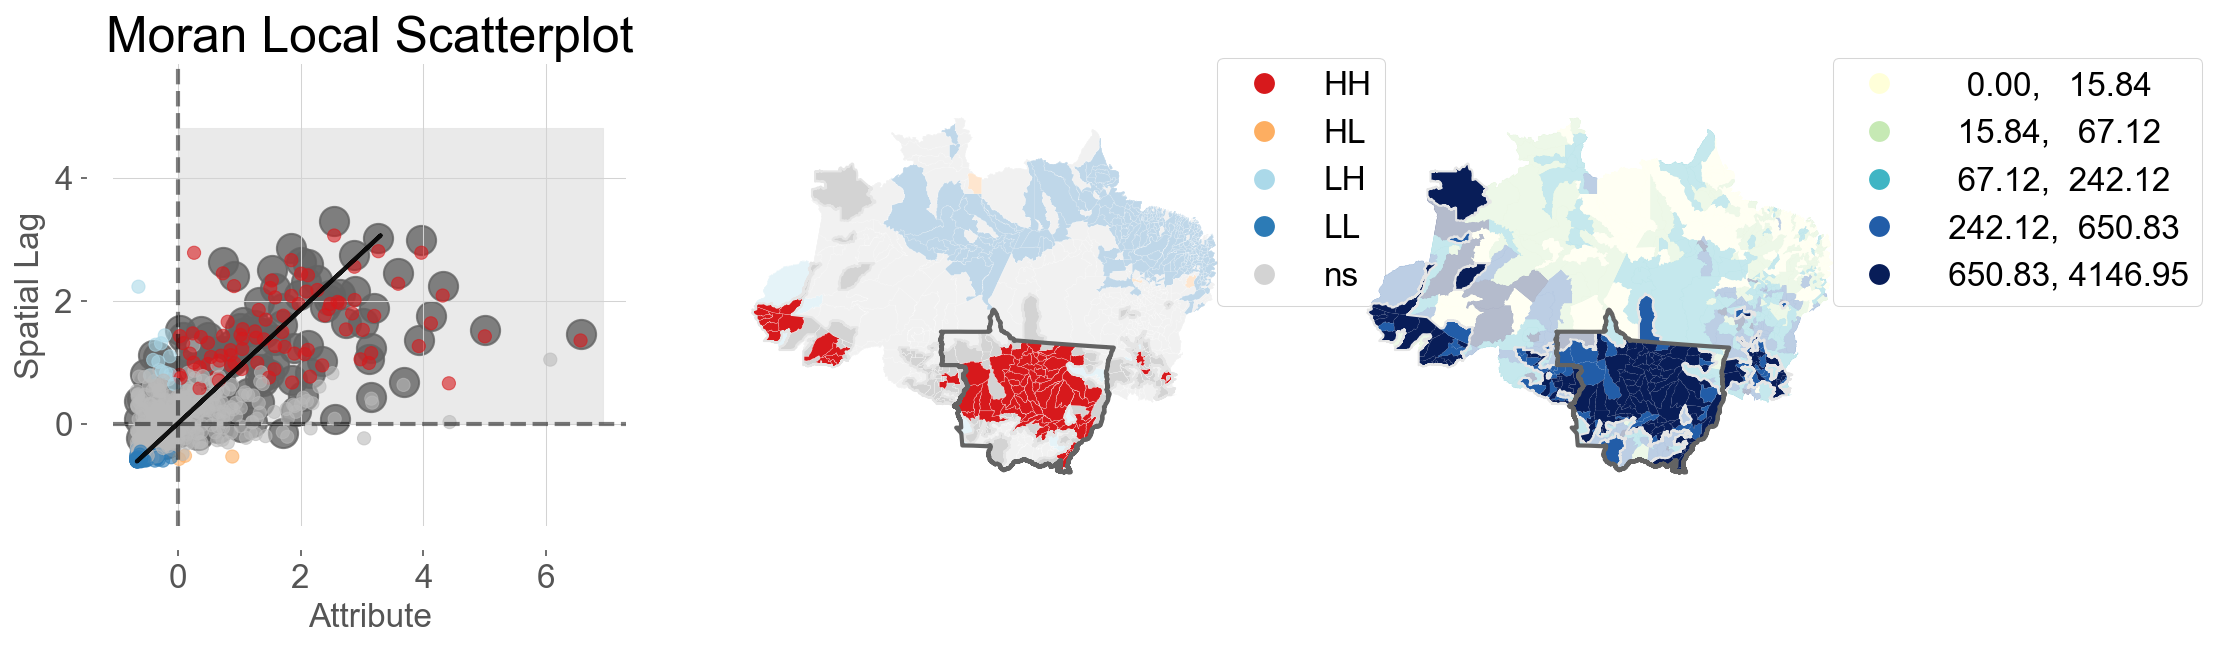

In [24]:
# Focusing on Mato Grosso
fig = plot_local_autocorrelation(moran_loc, gdf, y, p=0.05,
                                 region_column='id_uf',
                                 mask=[51], 
                                 quadrant=1);